In [45]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import matplotlib.pyplot as plt
import SolveLinSys
import time
from utilities import compute_derivatives_2d, find_nearest_value
from numba import njit

In [46]:
def false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_z.reshape(-1, 1, order='F'), B_y.reshape(-1, 1, order='F')])
    C = np.hstack([C_zz.reshape(-1, 1, order='F'), C_yy.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out

Equation:

\begin{align}
0 = \max_e \min_{h_2} \min_{\pi_j:\sum_j^J{\pi_j}=1} &-\delta \phi(y,z_2) + \delta\eta\log e + \xi_m \frac{(h_2)^2}{2} + \frac{\partial \phi}{\partial y}(y, z_2) z_2 e\\
&+ \left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\left[-\rho(z_2 - \mu_2) + \sqrt{z_2}\sigma_2 h_2\right] + \left[\frac{\partial^2 \phi}{\partial (z_2)^2}(y, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)\\
& + (\eta-1)\sum_{j}^J \pi_{j}\left(\frac{d}{d \tau}\Lambda_j(y)z_2 e\right)\\
& + \xi_a \sum_{j}^J \pi_{j} \left(\log \pi_j - \log \pi_j^o\right)
\end{align}

where

\begin{equation}
\Lambda_j(\tau)=
\begin{cases}
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2, & \tau\leq \bar{\tau} \\
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2 + \frac{\lambda_{2,j}^+}{2}(\tau-\bar{\tau})^2, & \tau > \bar{\tau}
\end{cases}
\end{equation}

FOC of $\pi_j$ gives:
$$
\pi_j \propto \exp\left[-\frac{1}{\xi_a}(\eta-1)\left(\frac{d}{d \tau}\Lambda_j(z_2 y) z_2 e \right)\right]\pi_j^o
$$

FOC of $h_2$ gives : 

\begin{align}
h_2^* = -\frac{\frac{\partial \phi}{\partial z_2}(y, z_2)\sqrt{z_2}\sigma_2}{\xi_m}
\end{align}

FOC of $e$ gives :

$$
e^* = -\frac{\delta \eta}{\frac{\partial \phi}{\partial y}(y, z_2)z_2 + (\eta-1)\sum_{j}^J\pi_j\frac{d}{d \tau}\Lambda_j(y)z_2}
$$

In [47]:
def false_transient(z_grid, y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    η, ξ_m, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o  = model_paras
    Δ_z = z_grid[1] - z_grid[0]
    Δ_y = y_grid[1] - y_grid[0]
    (z_mat, y_mat) = np.meshgrid(z_grid, y_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])
    if v0 is None:
        v0 = -δ*η*y_mat

    d_Λ = np.array([λ_1 + λ_2*y_mat + λ_2p_j*(y_mat>λ_bar)*(y_mat-λ_bar) for λ_2p_j in λ_2p])
    d_Λ_z = d_Λ * z_mat
    mean = - ρ*(z_mat-μ_2)
    std = np.sqrt(z_mat)*σ_2
    var = std**2/2.

    π = np.ones_like(d_Λ)
    for i in range(π.shape[0]):
        π[i] = π_o[i]
    π_o = π.copy()
    e = - δ*η / ((η-1)*np.sum(π*d_Λ_z, axis=0))

    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives_2d(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives_2d(v0, 0, 2, Δ_z)
        v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)

        log_π_ratio = -(η-1.)*d_Λ_z*e/ξ_a
        π_ratio = log_π_ratio - np.max(log_π_ratio, axis=0)
        π = np.exp(π_ratio) * π_o
        π = π/np.sum(π, axis=0)
        π[π<=0] = 1e-12
        
        h = - v0_dz*std/ξ_m
        e = - δ*η / (v0_dy*z_mat + (η-1)*np.sum(π*d_Λ_z, axis=0))
        e[e<=0] = 1e-12

        A = np.ones_like(z_mat)*(-δ)
        B_z = mean + std*h
        B_y = z_mat*e
        C_zz = var
        C_yy = np.zeros_like(z_mat)
        D = δ*η*np.log(e) + ξ_m*h**2/2 + (η-1)*np.sum(π*d_Λ_z*e, axis=0)\
            + ξ_a*np.sum(π*(np.log(π)-np.log(π_o)), axis=0)
        res = false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_z*v0_dz + B_y*v0_dy + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    return v0, e, h, π

In [59]:
# Model parameters
η = .032
# ξ_m = .0001
ξ_m = 1000
ξ_a = .001
δ = .01
# Z process
μ_2 = 1.86/1000.
ρ = 0.9
σ_2 = np.sqrt(2*ρ/10416.29)/2
# Damage setting
λ_1 = 1.7675/10000
λ_2 = 0.0022*2
λ_bar = 2.

# three damage
# λ_2p = np.array([0., 0.0197*2, 0.3853*2])
# π_o = np.array([0.475, 0.475, 0.05])

# two damage
λ_2p = np.array([0., 0.0197*2])
π_o = np.array([0.5, 0.5])

pde_paras = (η, ξ_m, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o)

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

# Grid setting
n_z = 50
z_min = np.max([μ_2 - 3*np.sqrt(σ_2**2*μ_2/(2*ρ)), 1e-9])
z_max = μ_2 + 3*np.sqrt(σ_2**2*μ_2/(2*ρ))
z_grid = np.linspace(z_min, z_max, n_z)

n_y = 50
y_min = 1e-10
y_max = 10.
y_grid = np.linspace(y_min, y_max, n_y)

In [60]:
ϕ_grid, e_grid, h_grid, π_grid = false_transient(z_grid, y_grid, model_paras=pde_paras,
                                         v0=None, ϵ=.5, tol=1e-8, max_iter=10_000)

Iteration 1: LHS Error: 0.0013946364054434504; RHS Error 0.0016812083027593584
Iteration 2: LHS Error: 0.00130049747613473; RHS Error 0.0014499204921465034
Iteration 3: LHS Error: 0.0012208758950239822; RHS Error 0.0013127073206536288
Iteration 4: LHS Error: 0.0011592465411852729; RHS Error 0.0012223482559414135
Iteration 5: LHS Error: 0.0011107728983411119; RHS Error 0.0011573340152030514
Iteration 6: LHS Error: 0.0010714332897576347; RHS Error 0.00110753995411178
Iteration 7: LHS Error: 0.0010385447776441754; RHS Error 0.0010676123839470108
Iteration 8: LHS Error: 0.0010103409335917076; RHS Error 0.0010344443645468107
Iteration 9: LHS Error: 0.0009856350342299838; RHS Error 0.001006107687753971
Iteration 10: LHS Error: 0.0009636095011807035; RHS Error 0.0009813450793941482
Iteration 11: LHS Error: 0.0009436871586487577; RHS Error 0.0009593049342381539
Iteration 12: LHS Error: 0.0009254512266378516; RHS Error 0.000939392349378011
Iteration 13: LHS Error: 0.0009085943717691246; RHS Err

Iteration 105: LHS Error: 0.00035612620243134774; RHS Error 0.00035749667039051936
Iteration 106: LHS Error: 0.0003530072447517213; RHS Error 0.0003543641020915106
Iteration 107: LHS Error: 0.0003499171282655006; RHS Error 0.00035126053709326206
Iteration 108: LHS Error: 0.0003468555520627359; RHS Error 0.00034818567107738137
Iteration 109: LHS Error: 0.0003438222212851366; RHS Error 0.0003451392064747267
Iteration 110: LHS Error: 0.00034081684470432805; RHS Error 0.00034212084844764657
Iteration 111: LHS Error: 0.0003378391367473005; RHS Error 0.0003391303075651232
Iteration 112: LHS Error: 0.00033488881524793013; RHS Error 0.00033616729891154423
Iteration 113: LHS Error: 0.00033196560292760025; RHS Error 0.0003332315425144919
Iteration 114: LHS Error: 0.0003290692253795635; RHS Error 0.00033032276091236445
Iteration 115: LHS Error: 0.0003261994150681319; RHS Error 0.0003274406845433531
Iteration 116: LHS Error: 0.00032335590595869435; RHS Error 0.00032458504542268337
Iteration 117: L

Iteration 205: LHS Error: 0.00015040961334604475; RHS Error 0.00015093637562403302
Iteration 206: LHS Error: 0.00014914242952827894; RHS Error 0.0001496643375771291
Iteration 207: LHS Error: 0.000147886324619928; RHS Error 0.00014840342627858597
Iteration 208: LHS Error: 0.00014664119620905192; RHS Error 0.0001471535393456965
Iteration 209: LHS Error: 0.00014540694318336544; RHS Error 0.00014591457536557325
Iteration 210: LHS Error: 0.00014418346559344486; RHS Error 0.00014468643235638257
Iteration 211: LHS Error: 0.0001429706640724282; RHS Error 0.00014346901047511168
Iteration 212: LHS Error: 0.00014176844056186522; RHS Error 0.00014226221312241911
Iteration 213: LHS Error: 0.00014057669757332192; RHS Error 0.00014106594056225233
Iteration 214: LHS Error: 0.00013939533905138468; RHS Error 0.0001398800981825798
Iteration 215: LHS Error: 0.00013822426943443933; RHS Error 0.0001387045870608958
Iteration 216: LHS Error: 0.0001370633943708205; RHS Error 0.0001375393154193636
Iteration 217

Iteration 310: LHS Error: 7.688652881721048e-05; RHS Error 7.747357574952387e-05
Iteration 311: LHS Error: 7.650910388304344e-05; RHS Error 7.709617718978121e-05
Iteration 312: LHS Error: 7.613353082790153e-05; RHS Error 7.672063035224272e-05
Iteration 313: LHS Error: 7.575980057089593e-05; RHS Error 7.63469263505328e-05
Iteration 314: LHS Error: 7.538790406191875e-05; RHS Error 7.597505558733147e-05
Iteration 315: LHS Error: 7.501783244753812e-05; RHS Error 7.560500971707485e-05
Iteration 316: LHS Error: 7.464957654582105e-05; RHS Error 7.523677955267332e-05
Iteration 317: LHS Error: 7.42831275322986e-05; RHS Error 7.487035624853433e-05
Iteration 318: LHS Error: 7.391847668977714e-05; RHS Error 7.450573076802172e-05
Iteration 319: LHS Error: 7.355561499881869e-05; RHS Error 7.41428944473397e-05
Iteration 320: LHS Error: 7.319453382641228e-05; RHS Error 7.378183833297778e-05
Iteration 321: LHS Error: 7.283522433529366e-05; RHS Error 7.342255405900952e-05
Iteration 322: LHS Error: 7.247

Iteration 422: LHS Error: 4.430595479952559e-05; RHS Error 4.489527093402127e-05
Iteration 423: LHS Error: 4.4088410133175104e-05; RHS Error 4.467774138363216e-05
Iteration 424: LHS Error: 4.387193378747878e-05; RHS Error 4.4461279889527957e-05
Iteration 425: LHS Error: 4.365651992564723e-05; RHS Error 4.4245880298736135e-05
Iteration 426: LHS Error: 4.344216315721461e-05; RHS Error 4.40315380698474e-05
Iteration 427: LHS Error: 4.32288584674978e-05; RHS Error 4.3818247781893195e-05
Iteration 428: LHS Error: 4.301660068337099e-05; RHS Error 4.360600425119227e-05
Iteration 429: LHS Error: 4.280538461340355e-05; RHS Error 4.339480265178598e-05
Iteration 430: LHS Error: 4.259520517461979e-05; RHS Error 4.318463739655986e-05
Iteration 431: LHS Error: 4.2386057364729446e-05; RHS Error 4.297550366002105e-05
Iteration 432: LHS Error: 4.217793603839004e-05; RHS Error 4.276739656014982e-05
Iteration 433: LHS Error: 4.197083611985619e-05; RHS Error 4.2560310738122054e-05
Iteration 434: LHS Error

Iteration 530: LHS Error: 2.6035719307995753e-05; RHS Error 2.6626262645545746e-05
Iteration 531: LHS Error: 2.5907854407522524e-05; RHS Error 2.649840641462815e-05
Iteration 532: LHS Error: 2.5780616779561005e-05; RHS Error 2.637117784433436e-05
Iteration 533: LHS Error: 2.565400526172157e-05; RHS Error 2.6244573695587457e-05
Iteration 534: LHS Error: 2.552801424932083e-05; RHS Error 2.6118591037430203e-05
Iteration 535: LHS Error: 2.5402641769173284e-05; RHS Error 2.5993227200007458e-05
Iteration 536: LHS Error: 2.527788488149163e-05; RHS Error 2.58684786564394e-05
Iteration 537: LHS Error: 2.5153740357844456e-05; RHS Error 2.5744342524914454e-05
Iteration 538: LHS Error: 2.5030207311871333e-05; RHS Error 2.5620818006710208e-05
Iteration 539: LHS Error: 2.4907276059499273e-05; RHS Error 2.5497893964440102e-05
Iteration 540: LHS Error: 2.4784954471238074e-05; RHS Error 2.5375580461777203e-05
Iteration 541: LHS Error: 2.466322666754006e-05; RHS Error 2.5253860653732835e-05
Iteration 54

Iteration 639: LHS Error: 1.5222654768581867e-05; RHS Error 1.581390925916459e-05
Iteration 640: LHS Error: 1.5147878488955269e-05; RHS Error 1.573913736183178e-05
Iteration 641: LHS Error: 1.507346907422824e-05; RHS Error 1.5664732564013226e-05
Iteration 642: LHS Error: 1.4999424968020758e-05; RHS Error 1.5590693213508194e-05
Iteration 643: LHS Error: 1.492574432830629e-05; RHS Error 1.5517017368074637e-05
Iteration 644: LHS Error: 1.4852425513856016e-05; RHS Error 1.5443703349340705e-05
Iteration 645: LHS Error: 1.4779466647504846e-05; RHS Error 1.5370749345778743e-05
Iteration 646: LHS Error: 1.4706866126659723e-05; RHS Error 1.529815349610587e-05
Iteration 647: LHS Error: 1.463462203787902e-05; RHS Error 1.5225914128953364e-05
Iteration 648: LHS Error: 1.4562732692902092e-05; RHS Error 1.5154029491356864e-05
Iteration 649: LHS Error: 1.449119627472406e-05; RHS Error 1.5082497837098506e-05
Iteration 650: LHS Error: 1.4420011212532002e-05; RHS Error 1.5011317470777852e-05
Iteration 6

Iteration 748: LHS Error: 8.899295836556353e-06; RHS Error 1.0289420975692696e-05
Iteration 749: LHS Error: 8.855572367974518e-06; RHS Error 1.0283604008922017e-05
Iteration 750: LHS Error: 8.812063640464829e-06; RHS Error 1.0277850842326441e-05
Iteration 751: LHS Error: 8.768768572031682e-06; RHS Error 1.0272162077535935e-05
Iteration 752: LHS Error: 8.725686118926657e-06; RHS Error 1.026653714857631e-05
Iteration 753: LHS Error: 8.682815245575348e-06; RHS Error 1.0260975525006478e-05
Iteration 754: LHS Error: 8.640154911546127e-06; RHS Error 1.0255476691548027e-05
Iteration 755: LHS Error: 8.597704089452485e-06; RHS Error 1.0250039995871258e-05
Iteration 756: LHS Error: 8.555461755668792e-06; RHS Error 1.0244665004319046e-05
Iteration 757: LHS Error: 8.513426885958797e-06; RHS Error 1.0239351142112235e-05
Iteration 758: LHS Error: 8.47159846179002e-06; RHS Error 1.0234097914330585e-05
Iteration 759: LHS Error: 8.429975473858708e-06; RHS Error 1.0228904682495676e-05
Iteration 760: LHS

Iteration 855: LHS Error: 5.253586937481458e-06; RHS Error 9.943721658179608e-06
Iteration 856: LHS Error: 5.227772749166748e-06; RHS Error 9.942404313500954e-06
Iteration 857: LHS Error: 5.202084887537262e-06; RHS Error 9.94111132444095e-06
Iteration 858: LHS Error: 5.176522810027007e-06; RHS Error 9.939842546183362e-06
Iteration 859: LHS Error: 5.151085985963255e-06; RHS Error 9.938597769986856e-06
Iteration 860: LHS Error: 5.12577387701274e-06; RHS Error 9.937376778540127e-06
Iteration 861: LHS Error: 5.1005859315472746e-06; RHS Error 9.936179355380477e-06
Iteration 862: LHS Error: 5.075521589695264e-06; RHS Error 9.935005262607711e-06
Iteration 863: LHS Error: 5.05058028152372e-06; RHS Error 9.933854266155591e-06
Iteration 864: LHS Error: 5.0257614270382556e-06; RHS Error 9.932726269387335e-06
Iteration 865: LHS Error: 5.0010644455089626e-06; RHS Error 9.931620895852335e-06
Iteration 866: LHS Error: 4.976488750987884e-06; RHS Error 9.930537961704814e-06
Iteration 867: LHS Error: 4.

Iteration 973: LHS Error: 2.9375066858960963e-06; RHS Error 9.906882751933898e-06
Iteration 974: LHS Error: 2.92306138892362e-06; RHS Error 9.9072438645423e-06
Iteration 975: LHS Error: 2.908689828481914e-06; RHS Error 9.907612922982739e-06
Iteration 976: LHS Error: 2.8943907042083827e-06; RHS Error 9.907986981237162e-06
Iteration 977: LHS Error: 2.880162752488813e-06; RHS Error 9.908368834832997e-06
Iteration 978: LHS Error: 2.8660051050594104e-06; RHS Error 9.908756362881114e-06
Iteration 979: LHS Error: 2.8519171087343365e-06; RHS Error 9.909150669721385e-06
Iteration 980: LHS Error: 2.837898374241643e-06; RHS Error 9.909551027116787e-06
Iteration 981: LHS Error: 2.8239484751307886e-06; RHS Error 9.909957714622616e-06
Iteration 982: LHS Error: 2.8100672774256097e-06; RHS Error 9.910370572641439e-06
Iteration 983: LHS Error: 2.796254001166676e-06; RHS Error 9.910790105392806e-06
Iteration 984: LHS Error: 2.7825085717053666e-06; RHS Error 9.911214855171232e-06
Iteration 985: LHS Error

Iteration 1081: LHS Error: 1.7251240498200593e-06; RHS Error 9.970672773098937e-06
Iteration 1082: LHS Error: 1.7166421158454348e-06; RHS Error 9.971390254211328e-06
Iteration 1083: LHS Error: 1.7082018819031264e-06; RHS Error 9.972108556695444e-06
Iteration 1084: LHS Error: 1.6998031312082107e-06; RHS Error 9.972827562571116e-06
Iteration 1085: LHS Error: 1.6914456716782267e-06; RHS Error 9.973547416027473e-06
Iteration 1086: LHS Error: 1.6831292975333367e-06; RHS Error 9.974267959438543e-06
Iteration 1087: LHS Error: 1.6748538072680619e-06; RHS Error 9.97498916682478e-06
Iteration 1088: LHS Error: 1.666618994811131e-06; RHS Error 9.975711002848677e-06
Iteration 1089: LHS Error: 1.658424667677627e-06; RHS Error 9.976433521241774e-06
Iteration 1090: LHS Error: 1.6502706221138697e-06; RHS Error 9.977156589388255e-06
Iteration 1091: LHS Error: 1.6421566612773164e-06; RHS Error 9.97788024474373e-06
Iteration 1092: LHS Error: 1.634082592127939e-06; RHS Error 9.978604457884033e-06
Iteration

Iteration 1189: LHS Error: 1.013054028262128e-06; RHS Error 1.0048007786022826e-05
Iteration 1190: LHS Error: 1.0080728204270306e-06; RHS Error 1.0048688132359603e-05
Iteration 1191: LHS Error: 1.0031161039175673e-06; RHS Error 1.0049367335961926e-05
Iteration 1192: LHS Error: 9.981837520572912e-07; RHS Error 1.0050045434632456e-05
Iteration 1193: LHS Error: 9.93275657987236e-07; RHS Error 1.0050722438106896e-05
Iteration 1194: LHS Error: 9.883916843034246e-07; RHS Error 1.0051398240952547e-05
Iteration 1195: LHS Error: 9.83531725201603e-07; RHS Error 1.0052072969754674e-05
Iteration 1196: LHS Error: 9.786956647050982e-07; RHS Error 1.0052746524196062e-05
Iteration 1197: LHS Error: 9.738833717798379e-07; RHS Error 1.0053418894509893e-05
Iteration 1198: LHS Error: 9.690947421481244e-07; RHS Error 1.0054090151921094e-05
Iteration 1199: LHS Error: 9.643296578348837e-07; RHS Error 1.0054760228324746e-05
Iteration 1200: LHS Error: 9.59587995799649e-07; RHS Error 1.0055429107951128e-05
Itera

Iteration 1297: LHS Error: 5.948568572583524e-07; RHS Error 1.011398724780658e-05
Iteration 1298: LHS Error: 5.919245226609915e-07; RHS Error 1.0114528146377088e-05
Iteration 1299: LHS Error: 5.890107843409265e-07; RHS Error 1.0115062175798033e-05
Iteration 1300: LHS Error: 5.861130250028879e-07; RHS Error 1.0115593191714167e-05
Iteration 1301: LHS Error: 5.83230022915826e-07; RHS Error 1.011612244252206e-05
Iteration 1302: LHS Error: 5.803612497939925e-07; RHS Error 1.0116650270552909e-05
Iteration 1303: LHS Error: 5.775065651525413e-07; RHS Error 1.0117176718419654e-05
Iteration 1304: LHS Error: 5.746713467452702e-07; RHS Error 1.0117701765907346e-05
Iteration 1305: LHS Error: 5.718484808875379e-07; RHS Error 1.0118225384450727e-05
Iteration 1306: LHS Error: 5.690384073109289e-07; RHS Error 1.0118747554787103e-05
Iteration 1307: LHS Error: 5.662414935964089e-07; RHS Error 1.0119268263304748e-05
Iteration 1308: LHS Error: 5.634579248181559e-07; RHS Error 1.0119787508371613e-05
Iterati

Iteration 1398: LHS Error: 3.6156774838036476e-07; RHS Error 1.0160707508987212e-05
Iteration 1399: LHS Error: 3.597897933194094e-07; RHS Error 1.016110017848786e-05
Iteration 1400: LHS Error: 3.5802057675449195e-07; RHS Error 1.0161491560760046e-05
Iteration 1401: LHS Error: 3.562600615486522e-07; RHS Error 1.0161881649464657e-05
Iteration 1402: LHS Error: 3.545082054162707e-07; RHS Error 1.0162270444843578e-05
Iteration 1403: LHS Error: 3.5276495888303394e-07; RHS Error 1.0162657960115402e-05
Iteration 1404: LHS Error: 3.5103028525607094e-07; RHS Error 1.0163044191066595e-05
Iteration 1405: LHS Error: 3.4930414181955083e-07; RHS Error 1.0163429143470316e-05
Iteration 1406: LHS Error: 3.4758648512212e-07; RHS Error 1.0163812818801948e-05
Iteration 1407: LHS Error: 3.458772751957495e-07; RHS Error 1.0164195216255494e-05
Iteration 1408: LHS Error: 3.4417646828377446e-07; RHS Error 1.016457634235796e-05
Iteration 1409: LHS Error: 3.4248402439041037e-07; RHS Error 1.0164956201615615e-05
I

Iteration 1502: LHS Error: 2.1654790567648963e-07; RHS Error 1.019510868650853e-05
Iteration 1503: LHS Error: 2.1548302785168172e-07; RHS Error 1.019538188293419e-05
Iteration 1504: LHS Error: 2.1442338232757763e-07; RHS Error 1.0195654073932446e-05
Iteration 1505: LHS Error: 2.133689454841825e-07; RHS Error 1.0195925268563543e-05
Iteration 1506: LHS Error: 2.123196889136647e-07; RHS Error 1.0196195475371751e-05
Iteration 1507: LHS Error: 2.1127559328426582e-07; RHS Error 1.0196464687232672e-05
Iteration 1508: LHS Error: 2.102366273432077e-07; RHS Error 1.0196732915036138e-05
Iteration 1509: LHS Error: 2.0920277273017707e-07; RHS Error 1.019700015748371e-05
Iteration 1510: LHS Error: 2.0817399959405236e-07; RHS Error 1.0197266422669066e-05
Iteration 1511: LHS Error: 2.0715028610507336e-07; RHS Error 1.0197531706605486e-05
Iteration 1512: LHS Error: 2.0613160309213008e-07; RHS Error 1.01977960152267e-05
Iteration 1513: LHS Error: 2.051179315842866e-07; RHS Error 1.0198059352500778e-05
I

Iteration 1617: LHS Error: 1.2288013304107004e-07; RHS Error 1.0220659267621635e-05
Iteration 1618: LHS Error: 1.222757714663958e-07; RHS Error 1.0220835808081512e-05
Iteration 1619: LHS Error: 1.2167437968280126e-07; RHS Error 1.0221011655500603e-05
Iteration 1620: LHS Error: 1.2107594610233363e-07; RHS Error 1.0221186812321725e-05
Iteration 1621: LHS Error: 1.2048045223977955e-07; RHS Error 1.0221361282032539e-05
Iteration 1622: LHS Error: 1.198878885194654e-07; RHS Error 1.0221535067101773e-05
Iteration 1623: LHS Error: 1.1929823656720018e-07; RHS Error 1.0221708167330586e-05
Iteration 1624: LHS Error: 1.1871148264397391e-07; RHS Error 1.0221880588739008e-05
Iteration 1625: LHS Error: 1.1812761244178738e-07; RHS Error 1.022205233279299e-05
Iteration 1626: LHS Error: 1.1754661442819891e-07; RHS Error 1.0222223402244998e-05
Iteration 1627: LHS Error: 1.1696847361519769e-07; RHS Error 1.0222393800983411e-05
Iteration 1628: LHS Error: 1.1639317057388077e-07; RHS Error 1.0222563525234883

Iteration 1740: LHS Error: 6.700627176725593e-08; RHS Error 1.0237849801805385e-05
Iteration 1741: LHS Error: 6.66766120926976e-08; RHS Error 1.0237957323191711e-05
Iteration 1742: LHS Error: 6.634857453724496e-08; RHS Error 1.023806440707232e-05
Iteration 1743: LHS Error: 6.602214779050097e-08; RHS Error 1.023817104484786e-05
Iteration 1744: LHS Error: 6.569732563521669e-08; RHS Error 1.0238277248035272e-05
Iteration 1745: LHS Error: 6.537410433826718e-08; RHS Error 1.0238383009573038e-05
Iteration 1746: LHS Error: 6.50524686063303e-08; RHS Error 1.0238488337945364e-05
Iteration 1747: LHS Error: 6.473241656590467e-08; RHS Error 1.0238593233490197e-05
Iteration 1748: LHS Error: 6.441393542166995e-08; RHS Error 1.0238697693049146e-05
Iteration 1749: LHS Error: 6.40970230642024e-08; RHS Error 1.0238801722834258e-05
Iteration 1750: LHS Error: 6.378166668430385e-08; RHS Error 1.0238905323366816e-05
Iteration 1751: LHS Error: 6.346786302069418e-08; RHS Error 1.0239008496783675e-05
Iteration

Iteration 1840: LHS Error: 4.0917042670729487e-08; RHS Error 1.0246662598162098e-05
Iteration 1841: LHS Error: 4.071563777796605e-08; RHS Error 1.0246733090993505e-05
Iteration 1842: LHS Error: 4.0515303403876324e-08; RHS Error 1.0246803790728634e-05
Iteration 1843: LHS Error: 4.031587846897722e-08; RHS Error 1.024687368629735e-05
Iteration 1844: LHS Error: 4.01175068859283e-08; RHS Error 1.0246943787309368e-05
Iteration 1845: LHS Error: 3.9920039607288516e-08; RHS Error 1.0247013093355405e-05
Iteration 1846: LHS Error: 3.9723615008480095e-08; RHS Error 1.024708260286705e-05
Iteration 1847: LHS Error: 3.952808344531711e-08; RHS Error 1.024715132000992e-05
Iteration 1848: LHS Error: 3.93335878312584e-08; RHS Error 1.0247220241982433e-05
Iteration 1849: LHS Error: 3.9139974011837e-08; RHS Error 1.0247288375493744e-05
Iteration 1850: LHS Error: 3.8947388605881095e-08; RHS Error 1.0247356712684468e-05
Iteration 1851: LHS Error: 3.87556732678318e-08; RHS Error 1.0247424273187992e-05
Iterati

Iteration 1944: LHS Error: 2.4529229342151737e-08; RHS Error 1.0252618551378828e-05
Iteration 1945: LHS Error: 2.4404804122024615e-08; RHS Error 1.0252667354700563e-05
Iteration 1946: LHS Error: 2.4316171035043688e-08; RHS Error 1.0252713003958591e-05
Iteration 1947: LHS Error: 2.4172533544253305e-08; RHS Error 1.0252751618157019e-05
Iteration 1948: LHS Error: 2.4048003408050356e-08; RHS Error 1.0252798656688834e-05
Iteration 1949: LHS Error: 2.395684783884633e-08; RHS Error 1.0252846095612608e-05
Iteration 1950: LHS Error: 2.381762968794998e-08; RHS Error 1.0252884822042983e-05
Iteration 1951: LHS Error: 2.369476431729467e-08; RHS Error 1.025293148233916e-05
Iteration 1952: LHS Error: 2.3575388641283723e-08; RHS Error 1.0252978281598073e-05
Iteration 1953: LHS Error: 2.3491991074653384e-08; RHS Error 1.0253022467913487e-05
Iteration 1954: LHS Error: 2.335227329564038e-08; RHS Error 1.0253060904816453e-05
Iteration 1955: LHS Error: 2.3231177204152686e-08; RHS Error 1.025310605519544e-0

Iteration 2060: LHS Error: 1.3847098301322802e-08; RHS Error 1.0256734757654613e-05
Iteration 2061: LHS Error: 1.3778767585237439e-08; RHS Error 1.0256761674394825e-05
Iteration 2062: LHS Error: 1.371085985024667e-08; RHS Error 1.0256789404616915e-05
Iteration 2063: LHS Error: 1.3643336974067388e-08; RHS Error 1.02568159094195e-05
Iteration 2064: LHS Error: 1.3575930282727633e-08; RHS Error 1.0256843470877824e-05
Iteration 2065: LHS Error: 1.3509103363729125e-08; RHS Error 1.0256869782071932e-05
Iteration 2066: LHS Error: 1.344247475831839e-08; RHS Error 1.0256896958261508e-05
Iteration 2067: LHS Error: 1.3376135546416812e-08; RHS Error 1.0256923131508455e-05
Iteration 2068: LHS Error: 1.3310220245421611e-08; RHS Error 1.0256950173091945e-05
Iteration 2069: LHS Error: 1.3244666002831806e-08; RHS Error 1.025697596712975e-05
Iteration 2070: LHS Error: 1.3179201105439908e-08; RHS Error 1.0257002748949025e-05
Iteration 2071: LHS Error: 1.3114327068741716e-08; RHS Error 1.0257028533383942e-

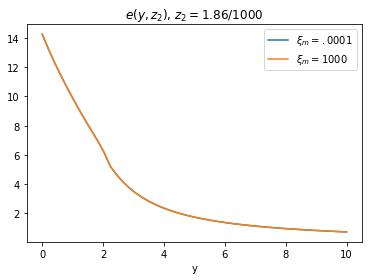

In [65]:
e_grid_small = np.load('e_grid_small.npy')
plt.plot(y_grid, e_grid[25], label=r'$\xi_m=.0001$')
plt.plot(y_grid, e_grid_small[25], label=r'$\xi_m=1000$')
plt.xlabel('y')
plt.legend()
plt.title(r'$e(y,z_2)$, $z_2=1.86/1000$')
plt.savefig('plot.pdf')

(0.0, 1.0)

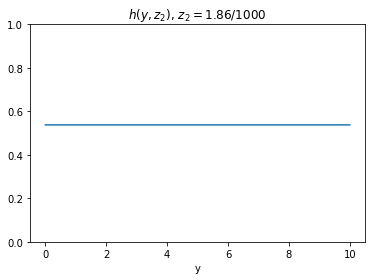

In [56]:
# plt.plot(y_grid, h_grid[25])
# plt.xlabel('y')
# plt.title(r'$h(y, z_2)$, $z_2=1.86/1000$')
# plt.ylim(0, 1)
# plt.savefig('plot.pdf')

In [21]:
@njit
def simulation(y_grid, z_grid, e_grid, h_grid, π_grid, yoz_start=290, z_loc=25, π_loc=0, T=100):
    Et = np.zeros(T+1)
    ht = np.zeros(T+1)
    πt = np.zeros(T+1)
    z = z_grid[z_loc]
    for i in range(T+1):
        Et[i] = np.interp(yoz_start*z, y_grid, e_grid[z_loc])
        ht[i] = np.interp(yoz_start*z, y_grid, h_grid[z_loc])
        πt[i] = np.interp(yoz_start*z, y_grid, π_grid[π_loc, z_loc])
        yoz_start = yoz_start + Et[i]
    return Et, ht, πt


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

In [22]:
T = 100
Et, ht, πt = simulation(y_grid, z_grid, e_grid, h_grid, π_grid, yoz_start=290, π_loc=0, z_loc=25, T=T)

Text(0.5, 0, 'Year')

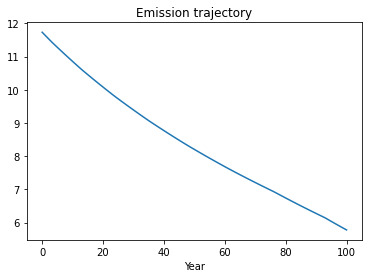

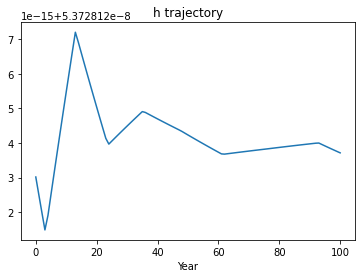

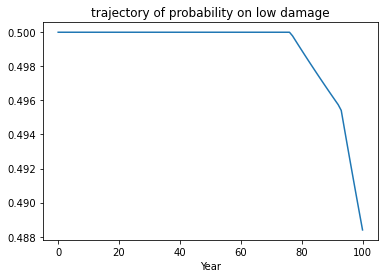

In [23]:
plt.figure()
plt.title('Emission trajectory')
plt.plot(Et)
plt.xlabel('Year')
plt.figure()
plt.title('h trajectory')
plt.plot(ht)
plt.xlabel('Year')
plt.figure()
plt.title('trajectory of probability on low damage')
plt.plot(πt)
plt.xlabel('Year')

In [ ]:
T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [ ]:
SCCt = η*(α-ioverk)*Kt/((1.-η)*Et)
# SCCt = η*(0.025)*Kt/((1.-η)*Et)

In [ ]:
plt.plot(SCCt[:21]*1000)
plt.ylim(0, None)
plt.title('Figure 1: Social cost of carbon')
plt.xlabel('Year')
# plt.savefig('figure_1.pdf')

In [ ]:
import pickle
with open('scc_bhh.pkl', 'rb') as f:
    scc_bhh = pickle.load(f)
with open('emission.pkl', 'rb') as f:
    emission_bbh = pickle.load(f)

In [ ]:
plt.plot(scc_bhh[0]['x'], scc_bhh[0]['y'])

In [ ]:
scc_low = np.array([scc_bhh[0]['y'][4*i] for i in range(21)])

### SCC formula

$$
SCC = \frac{\eta\left[\color{red}{\alpha - \left(\frac{i}{k}\right)^*}\right]K_t^*}{(1-\eta)E_t^*}
$$

(1) in BBH, $\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.025$.

(2) in the new paper, $\alpha=0.2, \left(\frac{i}{k}\right)^*=0.125$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.075$.

### Adjustment cost parameters

$\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$

From FOC of $\frac{i}{k}$, we have:
$$
1-\kappa \left(\frac{i}{k}\right)^* - \frac{\delta}{\alpha-\left(\frac{i}{k}\right)^*} = 0 
$$

Therefore $\kappa=6.667$

### Log damage evolution

$$
d\log N_t = \left[\frac{d}{d\tau}\Lambda(Z_{2,t} F_t)[E_tZ_t-\rho(Z_{2,t}-\mu_2)F_t]+\frac{1}{2}\frac{d^2}{d\tau^2}\Lambda(Z_{2,t}F_t)Z_{2,t}F_t^2\sigma_2^2\right]dt + \frac{d}{d\tau} \Lambda(Z_{2,t}F_t)F_t\sqrt{Z_{2,t}}\sigma_zdW_t
$$

where

$$
dZ_t^2 = -\rho(Z_t^2 - \mu_2) dt + \sqrt{Z_t^2}\sigma_2 d W_{2,t}
$$

$$
\Lambda(\tau) = \lambda_1 \tau + \frac{\lambda_2}{2} \tau^2
$$

In [ ]:
(1-δ/(α-ioverk))/ioverk

In [ ]:
-0.0429 + ioverk - κ/2.*ioverk**2

In [ ]:
plt.plot(SCCt[:21]*1000, label='new')
plt.plot(scc_low, label='BBH low damage')
plt.ylim(0, 150)
plt.xlabel('Year')
plt.legend()
plt.title('SCC comparison')
plt.savefig('scc.pdf')

In [ ]:
plt.plot(Et[:21], label='new')
plt.plot(emission_low, label='BBH low damage')
plt.ylim(0, 20)
plt.xlabel('Year')
plt.legend()
plt.title('Emission comparison')
plt.savefig('emission.pdf')

In [ ]:
emission_low = np.array([emission_bbh[0]['y'][4*i] for i in range(21)])